# Makine Öğrenmesi, Final Ödevi

Üsküdar Üniversitesi Fen Bilimleri Enstitüsü, Yapay Zeka Mühendisliği

Öğrenci: Muhammed Enes Baysan, [@mebaysan](https://mebaysan.com/)

GitHub: [@mebaysan/UskudarUniMLMidTerm](https://github.com/mebaysan/UskudarUniMLMidTerm)

# Veriseti - Pima Indians Diabetes Dataset

The Pima Indians Diabetes Dataset involves predicting the onset of diabetes within 5 years in Pima Indians given medical details.

It is a binary (2-class) classification problem. The number of observations for each class is not balanced. There are 768 observations with 8 input variables and 1 output variable. Missing values are believed to be encoded with zero values. 

The variable names are as follows:

- Number of times pregnant.
- Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
- Diastolic blood pressure (mm Hg).
- Triceps skinfold thickness (mm).
- 2-Hour serum insulin (mu U/ml).
- Body mass index (weight in kg/(height in m)^2).
- Diabetes pedigree function.
- Age (years).
- Class variable (0 or 1).

## Çalışma Hakkında Bilgilendirme

- Bu doküman boyunca geliştirici tarafından eklenen yorumlar, açıklamalar ve gerekli ek bilgiler ilgili kod bloğunun altında ayrı bir satırda <img src="images/note.webp" alt="note" width="30" height="30"/> iconu ile belirtilecektir.
- Bu çalışmada görselleştirme aracı olarak [Plotly](https://plotly.com/python/) kullanılmıştır. GitHub bu araç ile oluşturulan figürleri render edemediğinden dolayı figürler `figures` klasörü altına static `png` dosyaları olarak yazılmış olup tekrar bir alt satırda Markdown içerisine static olarak import edilmiştir. 

# Proje

In [39]:
import warnings
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [40]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 170)

In [41]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## Helpers

In [42]:
def missing_values_table(dataframe, na_name=False):
    """
    Eksik gözlem özet tablosu oluşturur
    """
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [43]:
def outlier_thresholds(dataframe, column_name, q1_rate=0.05, q3_rate=0.95):
    """
    Değişkenin IQR yöntemi için alt ve üst sınırlarını verir
    """
    q1 = dataframe[column_name].quantile(q1_rate)
    q3 = dataframe[column_name].quantile(q3_rate)
    iqr = q3 - q1
    low_limit = q1 - 1.5 * iqr
    up_limit = q3 + 1.5 * iqr
    return low_limit, up_limit

In [44]:
def check_outlier(dataframe, column_name, q1_rate=0.05, q3_rate=0.95):
    """
    Değişkende herhangi bir aykırı değer var mı?
    """
    low, up = outlier_thresholds(dataframe, column_name, q1_rate, q3_rate)
    if dataframe[(dataframe[column_name] < low) | (dataframe[column_name] > up)].any(axis=None):
        return True
    else:
        return False

In [45]:
def grab_outliers(dataframe, col_name, index=False, q1_rate=0.05, q3_rate=0.95):
    """
    Aykırı değerlere erişim
    """
    low, up = outlier_thresholds(dataframe, col_name, q1_rate, q3_rate)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [46]:
def replace_with_thresholds(dataframe, variable, q1_rate=0.05, q3_rate=0.95):
    """
    Outlier baskılama
    """
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1_rate, q3_rate)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [47]:
def export_fig_as_png(fig, name):
    if not os.path.exists("figures"):
        os.mkdir("figures")
    fig.write_image(f"figures/{name}.png")

In [48]:
def num_summary(dataframe, numerical_col, plot=False):
    """
    Numerik değişkeni özetler
    """
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        fig = px.histogram(df, x=numerical_col, nbins=20)
        fig.update_layout(bargap=0.2)
        fig.show()

In [49]:
def plot_roc_curve_plotly(model, X_test, y_test, fig_show = True):
    """
    ROC curve figure
    """
    # Tahmin edilen olasılıkları al
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # ROC eğrisi değerlerini hesapla
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    # ROC eğrisini çiz
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random Guessing'))
    fig.update_layout(title='Receiver Operating Characteristic (ROC) Curve',
                      xaxis_title='False Positive Rate',
                      yaxis_title='True Positive Rate')
    if fig_show:
        fig.show()
    return fig

## EDA (Exploratory Data Analysis)

In [50]:
df = pd.read_csv("veri-seti.txt", sep='\\s+', header=None)

In [51]:
df.columns = ["preg", "plas", "pres", "skin", "test", "mass", "pedi", "age", "class"]

In [52]:
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [53]:
df.shape

(768, 9)

### Outliers

<img src="images/note.webp" alt="note" width="30" height="30"/> IQR (inter quantile range) yöntemi ile verisetindeki aykırı gözlemler (0.05 ve 0.95 uç sınırları) incelenmiştir. Uç limitlerin dışında kalan gözlemler aykırı olarak değerlendirilmiştir.

In [54]:
for col_name in df.columns:
    has_outliers = check_outlier(df, col_name, 0.05, 0.95)
    if has_outliers:
        print(f"**{col_name}** değişkeni aykırı değerlere SAHİP.")
    else:
        print(f"{col_name} değişkeni aykırı değerlere sahip değil.")

preg değişkeni aykırı değerlere sahip değil.
plas değişkeni aykırı değerlere sahip değil.
pres değişkeni aykırı değerlere sahip değil.
skin değişkeni aykırı değerlere sahip değil.
**test** değişkeni aykırı değerlere SAHİP.
mass değişkeni aykırı değerlere sahip değil.
pedi değişkeni aykırı değerlere sahip değil.
age değişkeni aykırı değerlere sahip değil.
class değişkeni aykırı değerlere sahip değil.


#### Outlier Analysis, test variable

In [55]:
up_threshold_95 = outlier_thresholds(df, 'test', 0.05, 0.95)[1]
print("0.95 threshold: ", up_threshold_95)

0.95 threshold:  732.5


In [56]:
up_threshold_75 = outlier_thresholds(df, 'test', 0.05, 0.75)[1]
print("0.75 threshold: ", up_threshold_75)

0.75 threshold:  318.125


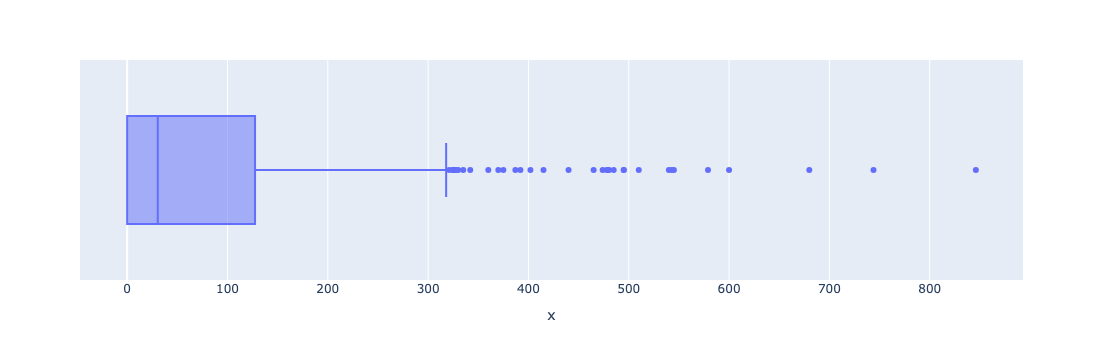

In [57]:
fig = px.box([], df['test'])
fig.show()
export_fig_as_png(fig, "fig1")

![Fig1](./figures/fig1.png)

<img src="images/note.webp" alt="note" width="30" height="30"/> Aykırı değerleri ise alt ve üst limitlere göre baskılayarak (replace) kontrol altına almaya karar verdim. `test` değişkeni için Boxplot'u incelediğimde aykırı değerler için yukarı limitini 0.95 yaptığımda aslında daha çok aykırı değeri yakaladığımı gözlemledim. Bu sebeple up threshold'unu 0.75 olarak belirleyip aykırı değerleri threshold değerleri ile baskılamanın uygun olup olmayacağını gözlemlemek istiyorum.

In [58]:
grab_outliers(df, "test", True, 0.05, 0.95)

     preg  plas  pres  skin  test  mass   pedi  age  class
13      1   189    60    23   846  30.1  0.398   59      1
228     4   197    70    39   744  36.7  2.329   31      0


Index([13, 228], dtype='int64')

In [59]:
grab_outliers(df, "test", True, 0.05, 0.75)

     preg  plas  pres  skin  test  mass   pedi  age  class
8       2   197    70    45   543  30.5  0.158   53      1
13      1   189    60    23   846  30.1  0.398   59      1
54      7   150    66    42   342  34.7  0.718   42      0
111     8   155    62    26   495  34.0  0.543   46      1
139     5   105    72    29   325  36.9  0.159   28      0


Index([8, 13, 54, 111, 139, 153, 186, 220, 228, 231, 247, 248, 258, 286, 296, 360, 370, 375, 392, 409, 415, 480, 486, 519, 574, 584, 612, 645, 655, 695, 707, 710, 715,
       753],
      dtype='int64')

In [60]:
df.loc[(df["test"] > up_threshold_75), :]

,preg,plas,pres,skin,test,mass,pedi,age,class
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
54,7,150,66,42,342,34.7,0.718,42,0
111,8,155,62,26,495,34.0,0.543,46,1
139,5,105,72,29,325,36.9,0.159,28,0
...,...,...,...,...,...,...,...,...,...
695,7,142,90,24,480,30.4,0.128,43,1
707,2,127,46,21,335,34.4,0.176,22,0
710,3,158,64,13,387,31.2,0.295,24,0
715,7,187,50,33,392,33.9,0.826,34,1


<img src="images/note.webp" alt="note" width="30" height="30"/> Verisetine baktığımda threshold'u 0.75'e çekip yukarı değerleri baskılarsam verinin yapısının bozulacağını gözlemliyorum. Bu sebeple 0.95'den yukarı olan değerleri baskılayarak devam ediyorum.

In [61]:
replace_with_thresholds(df, "test")

In [62]:
grab_outliers(df, "test", True, 0.05, 0.95)

Empty DataFrame
Columns: [preg, plas, pres, skin, test, mass, pedi, age, class]
Index: []


Index([], dtype='int64')

<img src="images/note.webp" alt="note" width="30" height="30"/> `test` değişkeni için aykırı değerleri getirmek istediğimde bunların gelmediğini, baskılandığını görebiliyorum.

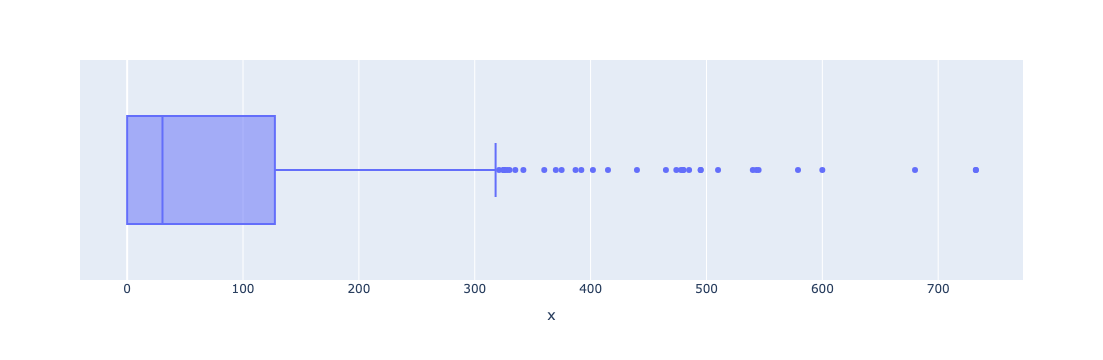

In [63]:
fig = px.box([], df['test'])
fig.show()
export_fig_as_png(fig, "fig2")

![fig2](./figures/fig2.png)

### Missing Values

In [64]:
df.iloc[:, :-1] = df.iloc[:, :-1].replace(0, np.nan)

In [65]:
missing_values_table(df)

      n_miss  ratio
test     374  48.70
skin     227  29.56
preg     111  14.45
pres      35   4.56
mass      11   1.43
plas       5   0.65


<img src="images/note.webp" alt="note" width="30" height="30"/> `missing_values_table` ile verisetimde eksik gözlem var mı diye kontrol ettiğimde hangi değişkende kaç tane eksik gözlem olduğunu yakalayabiliyorum. Verisetinin hikayesinde 0 olan değerlerin (output değişkeni hariç) aslında bilinmeyen değerler olduğu söylendiğinden bunları `np.nan` ile replace ettim. Bu sayede programatik olarak yakalayabiliyorum.

In [66]:
imp_mean = SimpleImputer(missing_values=np.nan, # eksik değerler ne ile temsil ediliyor
                            strategy='mean' # hangi yöntem ile değer atansın: mean, median, most_frequent, constant
)  
imp_mean.fit(df)
df_imputed = pd.DataFrame(imp_mean.transform(df), columns=df.columns)

In [67]:
df["preg"] = df_imputed["preg"]
df["plas"] = df_imputed["plas"]
df["pres"] = df_imputed["pres"]
df["skin"] = df_imputed["skin"]
df["test"] = df_imputed["test"]
df["mass"] = df_imputed["mass"]
df["pedi"] = df_imputed["pedi"]
df["age"] = df_imputed["age"]

<img src="images/note.webp" alt="note" width="30" height="30"/> `SimpleImputer` yardımı ile `mean` istatistiğine bakarak ürettiğim eksik gözlem değerlerini orjinal veri setime atadım.

### Scaling, Normalization

****************************************preg****************************************
count    768.000000
mean       4.494673
std        2.975395
min        1.000000
5%         1.000000
10%        1.000000
20%        2.000000
30%        2.000000
40%        3.000000
50%        4.494673
60%        4.494673
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: preg, dtype: float64


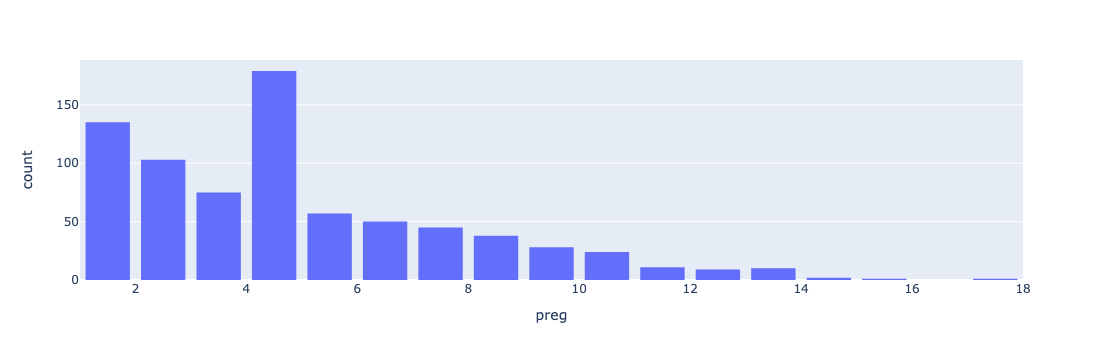

****************************************plas****************************************
count    768.000000
mean     121.686763
std       30.435949
min       44.000000
5%        80.000000
10%       86.700000
20%       95.000000
30%      102.100000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: plas, dtype: float64


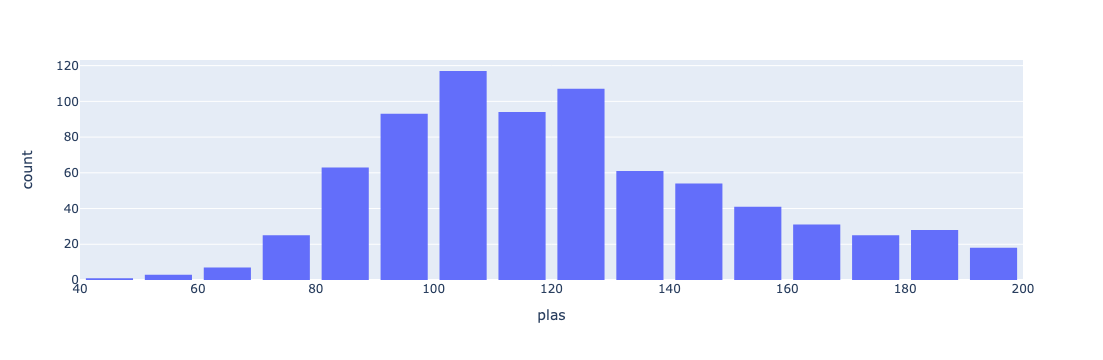

****************************************pres****************************************
count    768.000000
mean      72.405184
std       12.096346
min       24.000000
5%        52.000000
10%       58.000000
20%       62.000000
30%       66.000000
40%       70.000000
50%       72.202592
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: pres, dtype: float64


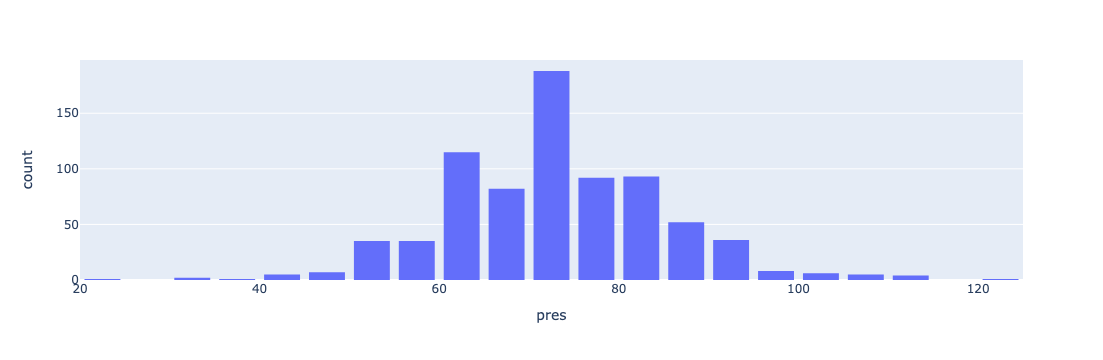

****************************************skin****************************************
count    768.000000
mean      29.153420
std        8.790942
min        7.000000
5%        14.350000
10%       18.000000
20%       23.000000
30%       27.000000
40%       29.153420
50%       29.153420
60%       29.153420
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: skin, dtype: float64


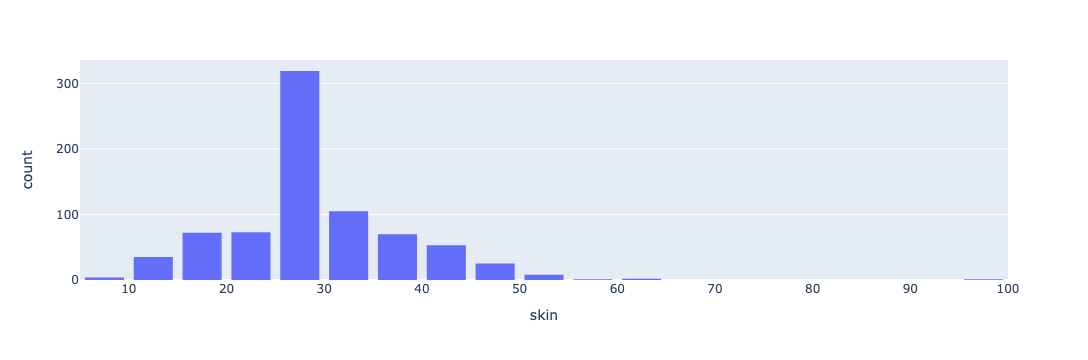

****************************************test****************************************
count    768.000000
mean     155.230964
std       83.806410
min       14.000000
5%        50.000000
10%       67.000000
20%      105.000000
30%      142.200000
40%      155.230964
50%      155.230964
60%      155.230964
70%      155.230964
80%      155.230964
90%      210.000000
95%      293.000000
99%      519.900000
max      732.500000
Name: test, dtype: float64


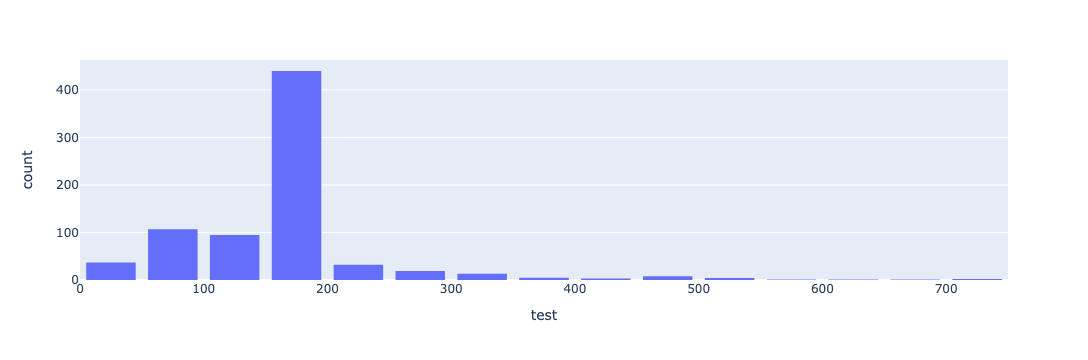

****************************************mass****************************************
count    768.000000
mean      32.457464
std        6.875151
min       18.200000
5%        22.235000
10%       24.000000
20%       26.200000
30%       28.500000
40%       30.400000
50%       32.400000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: mass, dtype: float64


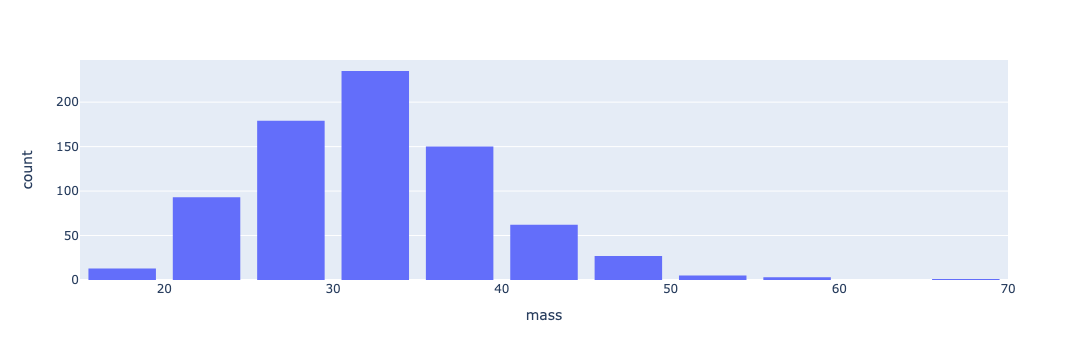

****************************************pedi****************************************
count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: pedi, dtype: float64


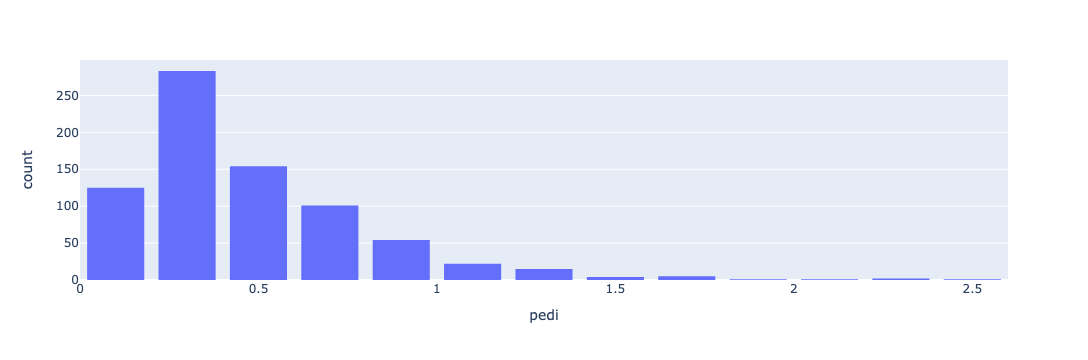

****************************************age****************************************
count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: age, dtype: float64


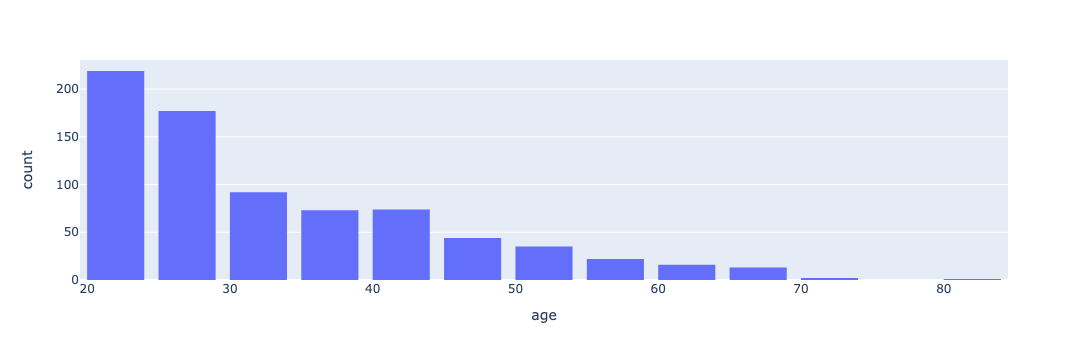

****************************************class****************************************
count    768.000000
mean       0.348958
std        0.476951
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%        0.000000
60%        0.000000
70%        1.000000
80%        1.000000
90%        1.000000
95%        1.000000
99%        1.000000
max        1.000000
Name: class, dtype: float64


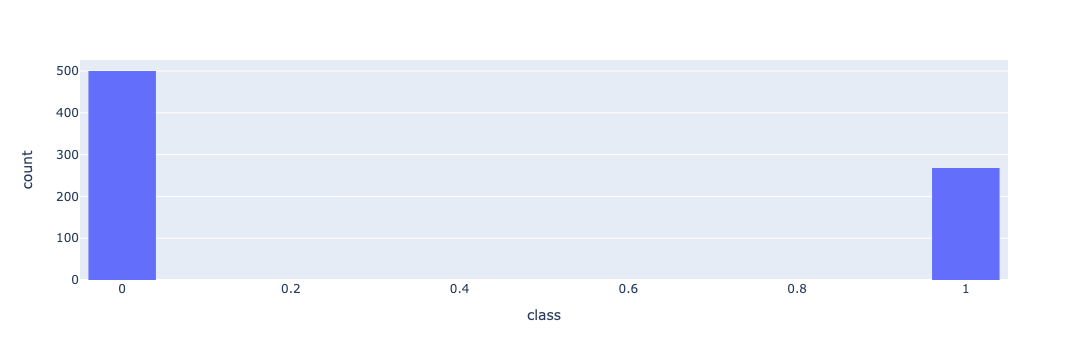

In [68]:
for col_name in df.columns:
    print(f"****************************************{col_name}****************************************")
    num_summary(df, col_name, True)

In [69]:
X = df.drop('class', axis=1)

In [70]:
y = df['class']

In [71]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
pca = PCA(n_components=2)

NameError: name 'PCA' is not defined

In [36]:
X_pca = pca.fit_transform(X_scaled)

NameError: name 'pca' is not defined

In [37]:
pca_components = pca.components_

NameError: name 'pca' is not defined

In [38]:
pca_explained_variance_ratio = pca.explained_variance_ratio_

NameError: name 'pca' is not defined

In [38]:
print("PCA Öznitelik Ağırlıkları:")
for i, component in enumerate(pca_components):
    print(f"PCA Bileşeni {i+1}:")
    for j, feature in enumerate(X.columns):
        print(f"{feature}: {component[j]} (Katkı: {pca_explained_variance_ratio[i] * 100:.2f}%)")

PCA Öznitelik Ağırlıkları:
PCA Bileşeni 1:
preg: 0.34826929097973164 (Katkı: 29.44%)
plas: 0.40934492685122637 (Katkı: 29.44%)
pres: 0.37779954286336603 (Katkı: 29.44%)
skin: 0.38759055148934846 (Katkı: 29.44%)
test: 0.31069225954411084 (Katkı: 29.44%)
mass: 0.3942938348544507 (Katkı: 29.44%)
pedi: 0.14502474616015107 (Katkı: 29.44%)
age: 0.3809945095226219 (Katkı: 29.44%)
PCA Bileşeni 2:
preg: -0.4989907176874508 (Katkı: 17.42%)
plas: 0.08316603273275489 (Katkı: 17.42%)
pres: -0.19433701408883775 (Katkı: 17.42%)
skin: 0.3566385331353743 (Katkı: 17.42%)
test: 0.19257685948426062 (Katkı: 17.42%)
mass: 0.4281634885702506 (Katkı: 17.42%)
pedi: 0.30073973484344024 (Katkı: 17.42%)
age: -0.5179570913040668 (Katkı: 17.42%)


In [39]:
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

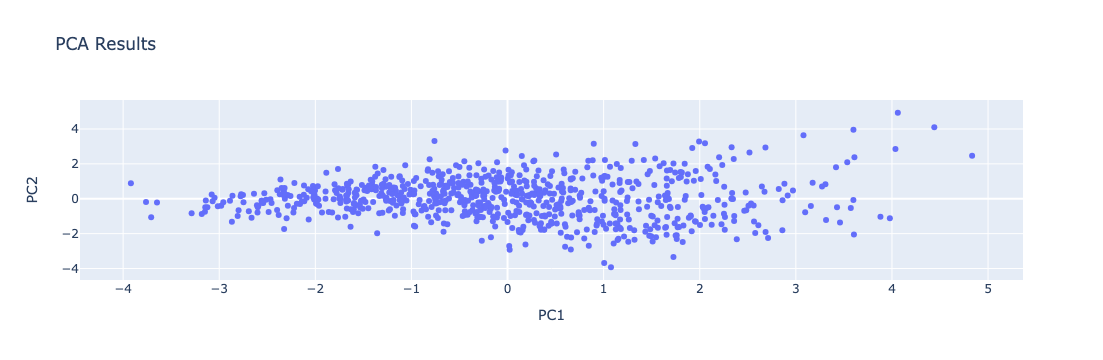

In [40]:
fig_pca = px.scatter(pca_df, x='PC1', y='PC2', title='PCA Results')
fig_pca.show()

# Model Kurma

## Train-Test Split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=6)

<img src="images/note.webp" alt="note" width="30" height="30"/> Farklı modellerin performansını aynı veriseti üzerinde karşılaştırabilmek için train ve test olarak bir kere bölüyorum. Her modelde aynı test ve train setlerini kullanıp en iyi performansı veren modele ulaşmaya çalışacağım.

**Model kurarken ve eğitim seti ayrılırken random state 6 olarak belirlenmiştir**

## Naive Bayes

In [72]:
def naive_bayes(X_train, y_train, X_test, y_test):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    y_pred_nb = nb_model.predict(X_test)
    
    print("\nNaive Bayes Performance Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_nb))
    print("Precision:", precision_score(y_test, y_pred_nb, average='macro'))
    print("Recall:", recall_score(y_test, y_pred_nb, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred_nb, average='macro'))
    plot_roc_curve_plotly(nb_model, X_test, y_test)
    
    return nb_model


Naive Bayes Performance Metrics:
Accuracy: 0.7705627705627706
Precision: 0.7435064935064934
Recall: 0.741955756661639
F1 Score: 0.7427130398234738


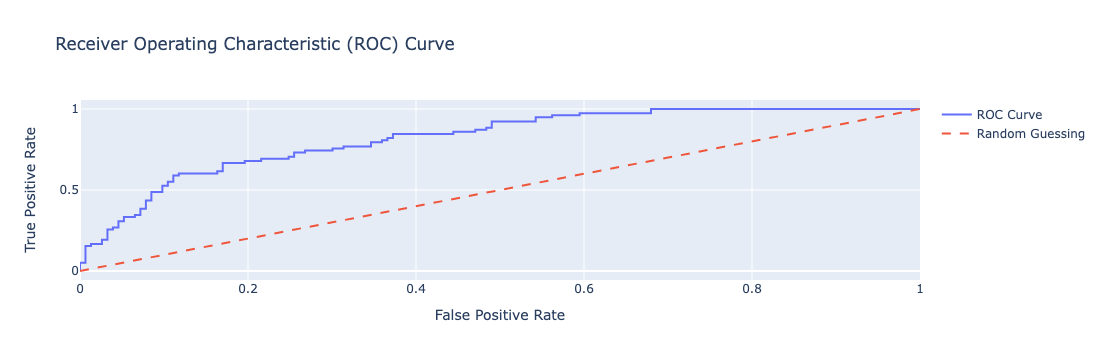

GaussianNB()

In [75]:
naive_bayes(X_train, y_train, X_test, y_test)

## K-Nearest Neighbors (K-NN)


In [123]:
def knn_classifier(n_neighbors, X_train, y_train, X_test, y_test):
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    
    print(f"\nK-Nearest Neighbors (K-NN) with {n_neighbors} neighbors Performance Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_knn))
    print("Precision:", precision_score(y_test, y_pred_knn, average='macro'))
    print("Recall:", recall_score(y_test, y_pred_knn, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred_knn, average='macro'))
    plot_roc_curve_plotly(knn_model, X_test, y_test)
    
    return knn_model


K-Nearest Neighbors (K-NN) with 2 neighbors Performance Metrics:
Accuracy: 0.70995670995671
Precision: 0.6753584643848289
Recall: 0.6270739064856712
F1 Score: 0.6325934718100891


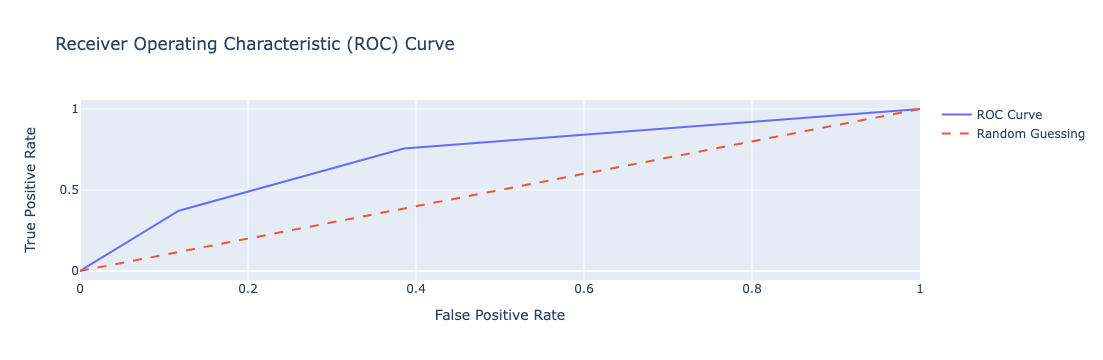

KNeighborsClassifier(n_neighbors=2)

In [124]:
knn_classifier(2, X_train, y_train, X_test, y_test)


K-Nearest Neighbors (K-NN) with 3 neighbors Performance Metrics:
Accuracy: 0.7186147186147186
Precision: 0.6889202256244964
Recall: 0.6964555052790347
F1 Score: 0.6919178447586023


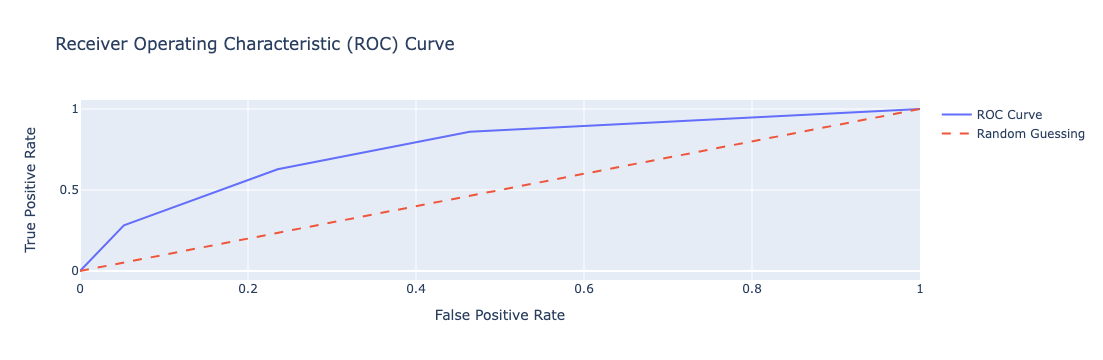

KNeighborsClassifier(n_neighbors=3)

In [125]:
knn_classifier(3, X_train, y_train, X_test, y_test)


K-Nearest Neighbors (K-NN) with 4 neighbors Performance Metrics:
Accuracy: 0.7272727272727273
Precision: 0.6960227272727273
Recall: 0.6589994972347913
F1 Score: 0.6674132138857782


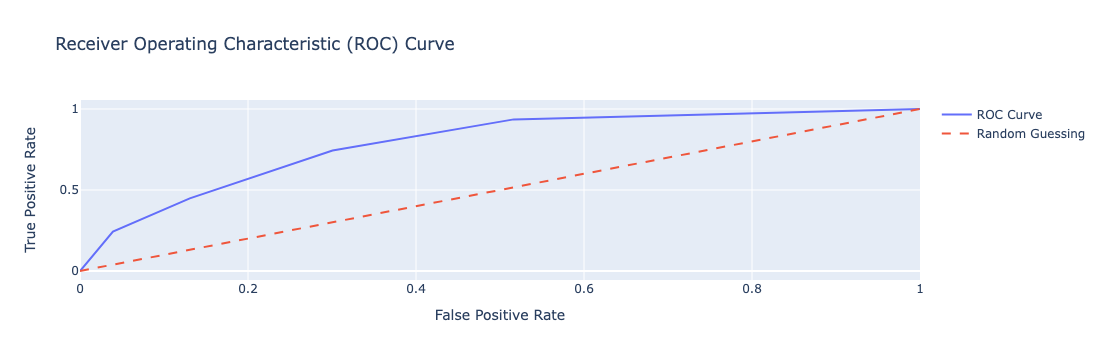

KNeighborsClassifier(n_neighbors=4)

In [126]:
knn_classifier(4, X_train, y_train, X_test, y_test)


K-Nearest Neighbors (K-NN) with 5 neighbors Performance Metrics:
Accuracy: 0.7272727272727273
Precision: 0.6954946702198535
Recall: 0.6967068878833584
F1 Score: 0.6960843688002506


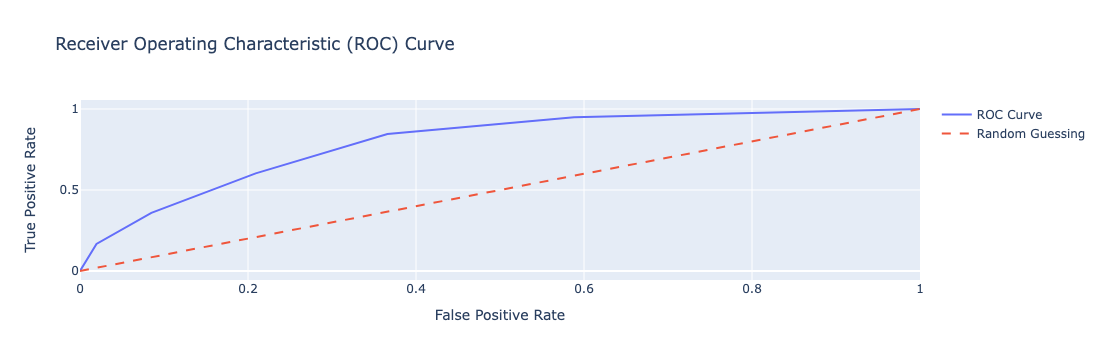

KNeighborsClassifier()

In [127]:
knn_classifier(5, X_train, y_train, X_test, y_test)


K-Nearest Neighbors (K-NN) with 10 neighbors Performance Metrics:
Accuracy: 0.7532467532467533
Precision: 0.7253475440222428
Recall: 0.7037456008044243
F1 Score: 0.711357607909332


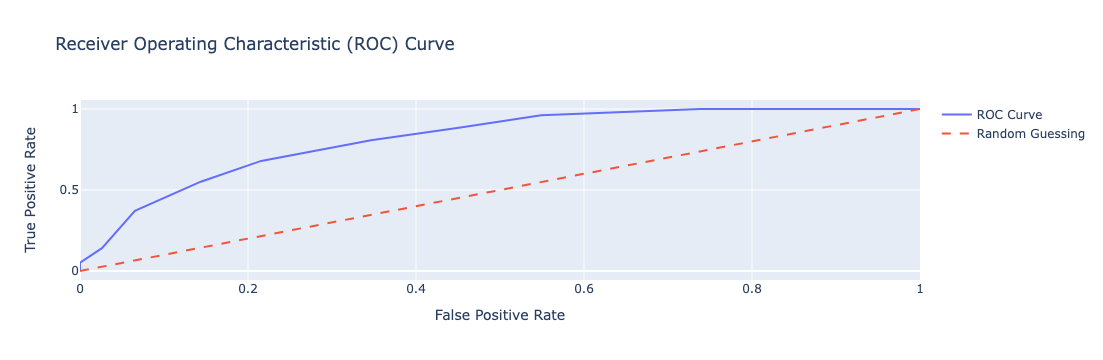

KNeighborsClassifier(n_neighbors=10)

In [128]:
knn_classifier(10, X_train, y_train, X_test, y_test)


K-Nearest Neighbors (K-NN) with 15 neighbors Performance Metrics:
Accuracy: 0.7575757575757576
Precision: 0.7288200339558574
Recall: 0.725867269984917
F1 Score: 0.7272727272727273


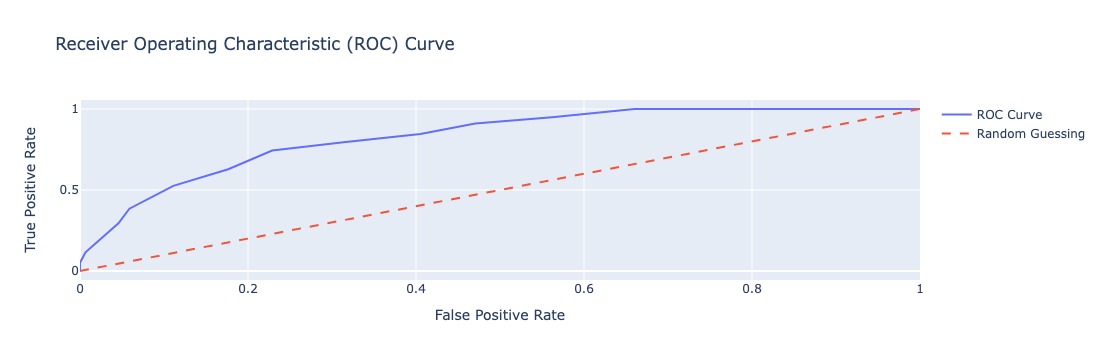

KNeighborsClassifier(n_neighbors=15)

In [129]:
knn_classifier(15, X_train, y_train, X_test, y_test)


K-Nearest Neighbors (K-NN) with 20 neighbors Performance Metrics:
Accuracy: 0.7705627705627706
Precision: 0.7442781690140845
Recall: 0.7325289089994973
F1 Score: 0.7374831142654974


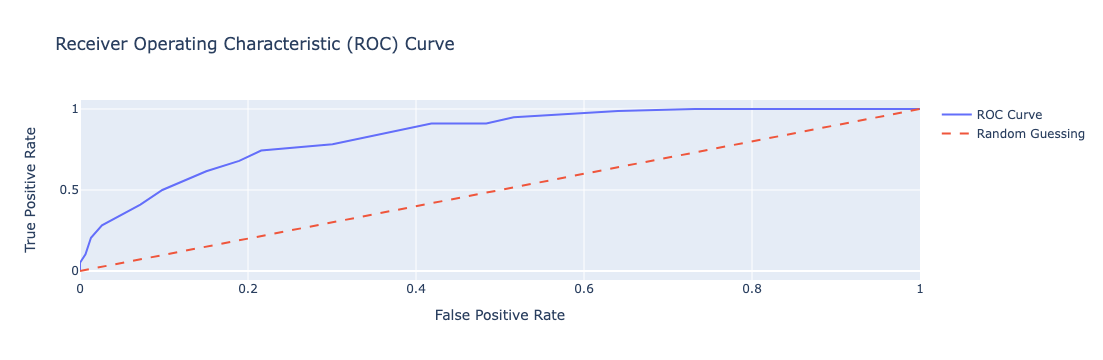

KNeighborsClassifier(n_neighbors=20)

In [130]:
knn_classifier(20, X_train, y_train, X_test, y_test)


K-Nearest Neighbors (K-NN) with 25 neighbors Performance Metrics:
Accuracy: 0.7619047619047619
Precision: 0.7338304144269117
Recall: 0.725992961287079
F1 Score: 0.7294563574029513


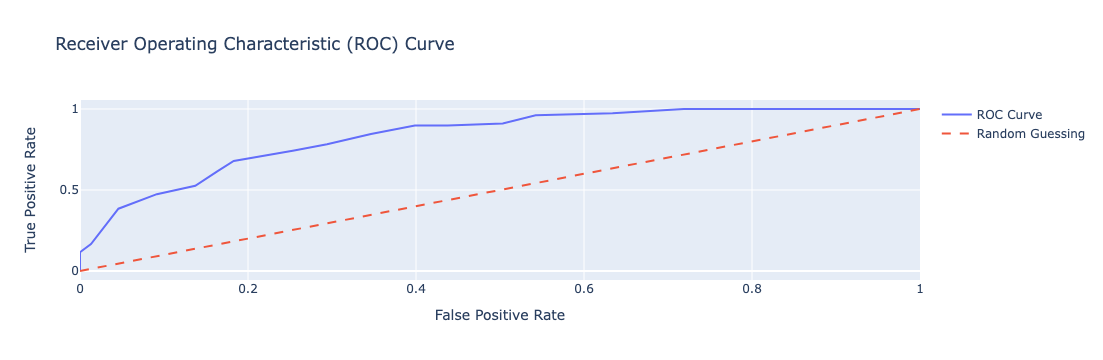

KNeighborsClassifier(n_neighbors=25)

In [131]:
knn_classifier(25, X_train, y_train, X_test, y_test)


K-Nearest Neighbors (K-NN) with 30 neighbors Performance Metrics:
Accuracy: 0.7705627705627706
Precision: 0.7495178399228544
Recall: 0.7168174962292609
F1 Score: 0.7273091743323608


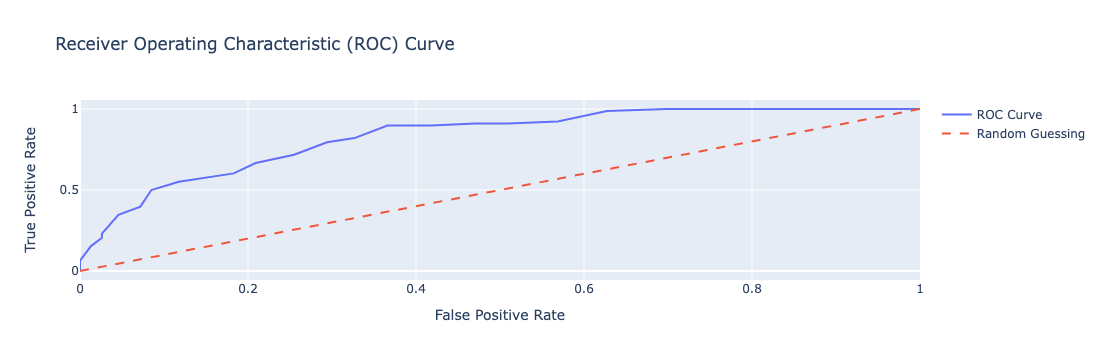

KNeighborsClassifier(n_neighbors=30)

In [132]:
knn_classifier(30, X_train, y_train, X_test, y_test)

## Multi-Layer Perceptron (MLP)

In [78]:
def mlp_classifier(hidden_layer_sizes, max_iter, X_train, y_train, X_test, y_test):
    mlp_model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=6)
    mlp_model.fit(X_train, y_train)
    y_pred_mlp = mlp_model.predict(X_test)
    
    print(f"\nMulti-Layer Perceptron (MLP) with hidden layers {hidden_layer_sizes} and {max_iter} iterations Performance Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
    print("Precision:", precision_score(y_test, y_pred_mlp, average='macro'))
    print("Recall:", recall_score(y_test, y_pred_mlp, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred_mlp, average='macro'))
    plot_roc_curve_plotly(mlp_model, X_test, y_test)
    
    return mlp_model


Multi-Layer Perceptron (MLP) with hidden layers 2 and 10 iterations Performance Metrics:
Accuracy: 0.6926406926406926
Precision: 0.6527728873239437
Recall: 0.6454248366013071
F1 Score: 0.6483264360915153


/Users/mebaysan/Workspace/ML-FINAL-ASSIGNMENT/UskudarUniMLMidTerm/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.



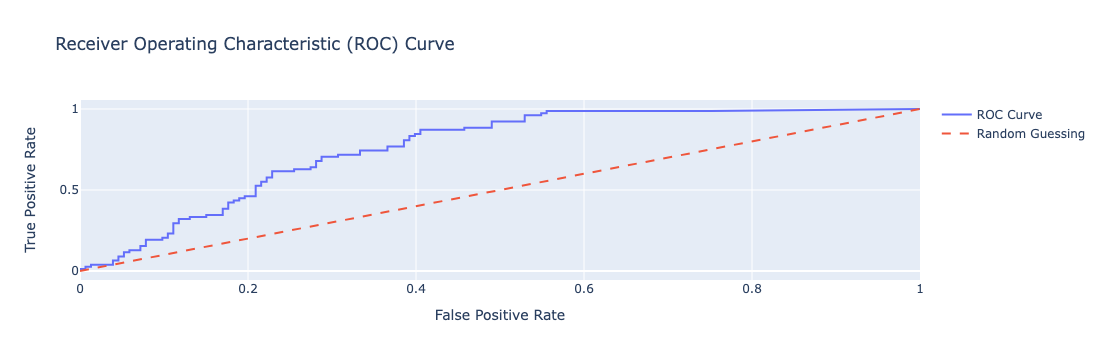

MLPClassifier(hidden_layer_sizes=2, max_iter=10, random_state=6)

In [133]:
mlp_classifier(2, 10, X_train, y_train, X_test, y_test)


Multi-Layer Perceptron (MLP) with hidden layers 2 and 100 iterations Performance Metrics:
Accuracy: 0.7878787878787878
Precision: 0.7740441466298777
Recall: 0.7330316742081449
F1 Score: 0.7457832678270635


/Users/mebaysan/Workspace/ML-FINAL-ASSIGNMENT/UskudarUniMLMidTerm/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



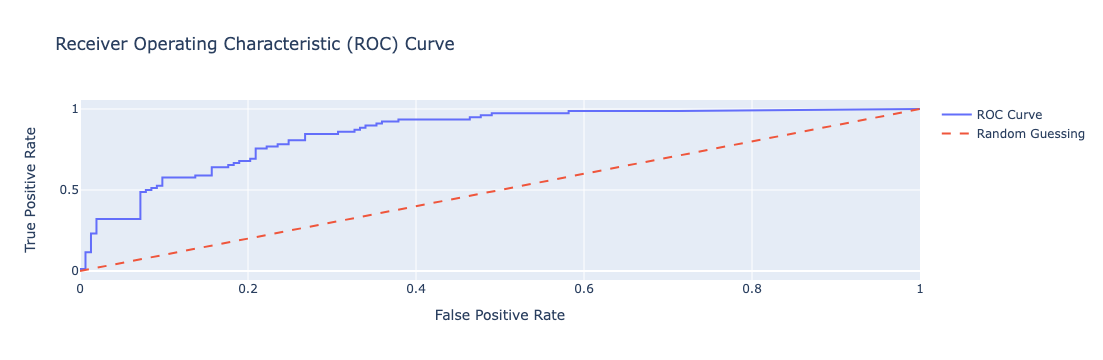

MLPClassifier(hidden_layer_sizes=2, max_iter=100, random_state=6)

In [134]:
mlp_classifier(2, 100, X_train, y_train, X_test, y_test)


Multi-Layer Perceptron (MLP) with hidden layers 5 and 10 iterations Performance Metrics:
Accuracy: 0.3593073593073593
Precision: 0.42135511191772534
Recall: 0.434640522875817
F1 Score: 0.35396825396825393


/Users/mebaysan/Workspace/ML-FINAL-ASSIGNMENT/UskudarUniMLMidTerm/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.



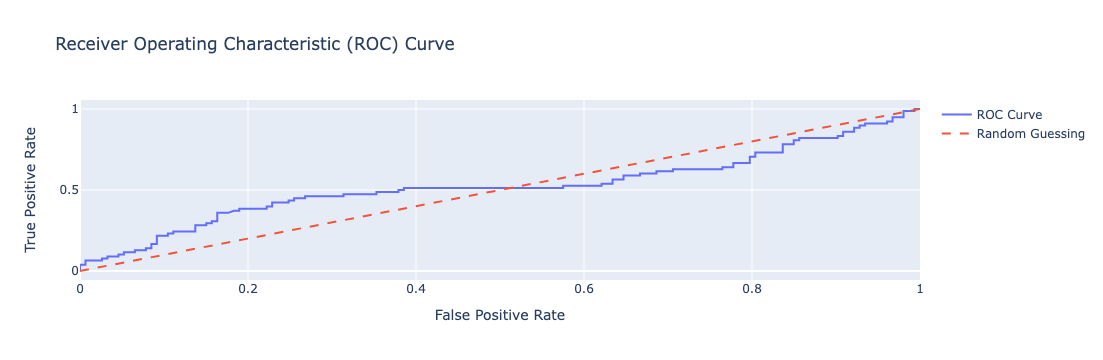

MLPClassifier(hidden_layer_sizes=5, max_iter=10, random_state=6)

In [135]:
mlp_classifier(5, 10, X_train, y_train, X_test, y_test)


Multi-Layer Perceptron (MLP) with hidden layers 5 and 100 iterations Performance Metrics:
Accuracy: 0.7662337662337663
Precision: 0.740909090909091
Recall: 0.7198340874811463
F1 Score: 0.7275943396226415


/Users/mebaysan/Workspace/ML-FINAL-ASSIGNMENT/UskudarUniMLMidTerm/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



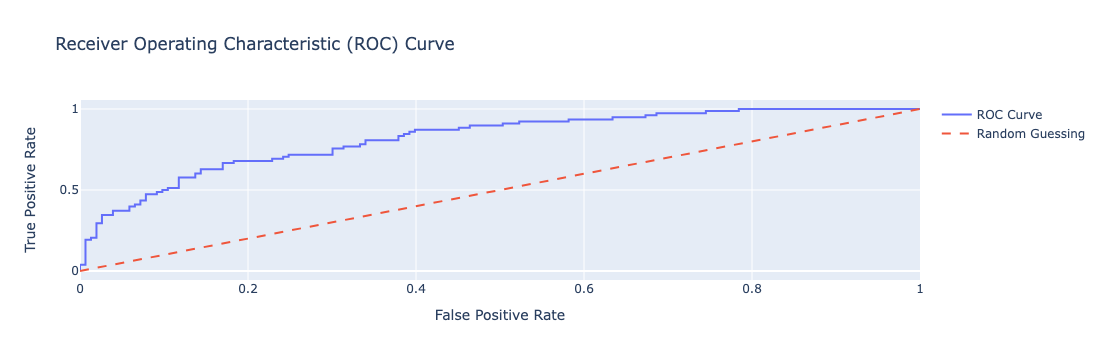

MLPClassifier(hidden_layer_sizes=5, max_iter=100, random_state=6)

In [136]:
mlp_classifier(5, 100, X_train, y_train, X_test, y_test)


Multi-Layer Perceptron (MLP) with hidden layers 10 and 10 iterations Performance Metrics:
Accuracy: 0.4675324675324675
Precision: 0.5005864873318736
Recall: 0.5006284565108094
F1 Score: 0.46556945358788676


/Users/mebaysan/Workspace/ML-FINAL-ASSIGNMENT/UskudarUniMLMidTerm/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.



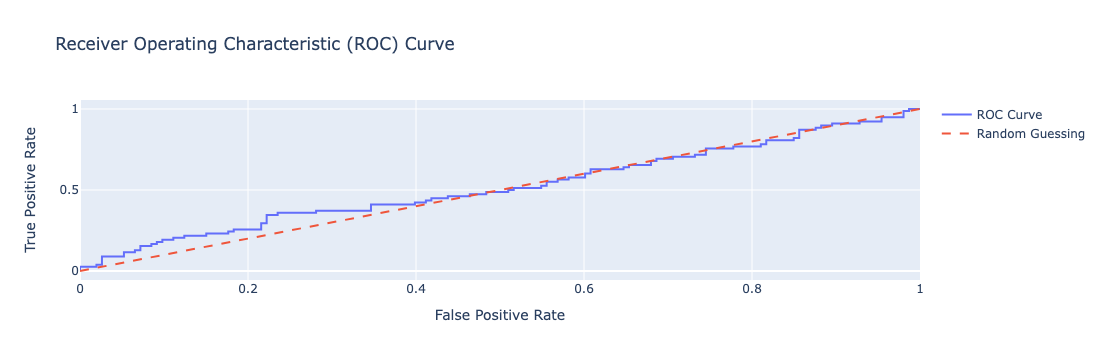

MLPClassifier(hidden_layer_sizes=10, max_iter=10, random_state=6)

In [137]:
mlp_classifier(10, 10, X_train, y_train, X_test, y_test)


Multi-Layer Perceptron (MLP) with hidden layers 10 and 100 iterations Performance Metrics:
Accuracy: 0.7705627705627706
Precision: 0.7438442864574302
Recall: 0.7356711915535445
F1 Score: 0.739294308042844


/Users/mebaysan/Workspace/ML-FINAL-ASSIGNMENT/UskudarUniMLMidTerm/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



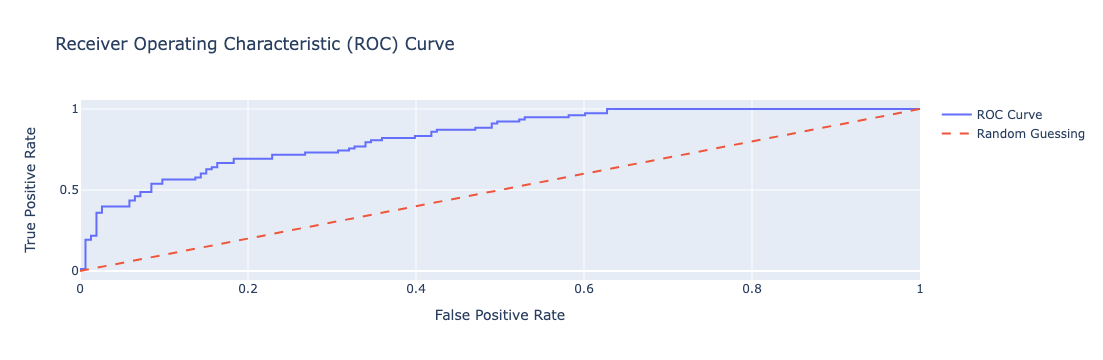

MLPClassifier(hidden_layer_sizes=10, max_iter=100, random_state=6)

In [138]:
mlp_classifier(10, 100, X_train, y_train, X_test, y_test)


Multi-Layer Perceptron (MLP) with hidden layers 2 and 300 iterations Performance Metrics:
Accuracy: 0.7922077922077922
Precision: 0.7713370624323349
Recall: 0.7520110608345902
F1 Score: 0.7596670712675568


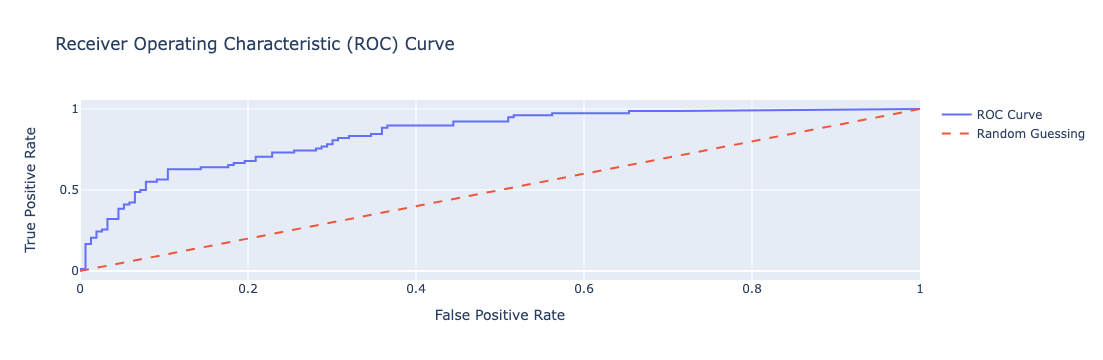

MLPClassifier(hidden_layer_sizes=2, max_iter=300, random_state=6)

In [145]:
mlp_classifier(2, 300, X_train, y_train, X_test, y_test)

## Support Vector Machine (SVM)

In [105]:
def svm_classifier(kernel, X_train, y_train, X_test, y_test):
    """
        Available kernels: 'linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed'
    """
    svm_model = SVC(kernel=kernel, probability=True, random_state=6)
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    
    print(f"\nSupport Vector Machine (SVM) with {kernel} kernel Performance Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_svm))
    print("Precision:", precision_score(y_test, y_pred_svm, average='macro'))
    print("Recall:", recall_score(y_test, y_pred_svm, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred_svm, average='macro'))
    plot_roc_curve_plotly(svm_model, X_test, y_test)
    
    return svm_model

In [117]:
SVM_KERNELS = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']


Support Vector Machine (SVM) with linear kernel Performance Metrics:
Accuracy: 0.7748917748917749
Precision: 0.7496894409937889
Recall: 0.7357968828557064
F1 Score: 0.7415217765536237


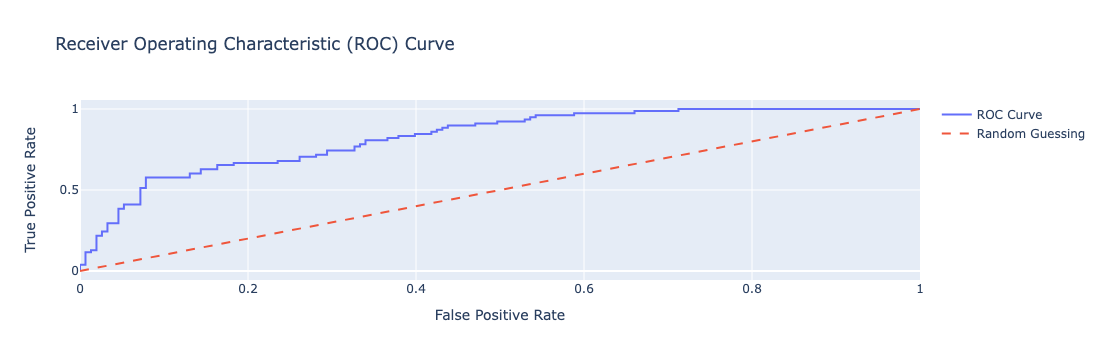


Support Vector Machine (SVM) with poly kernel Performance Metrics:
Accuracy: 0.7359307359307359
Precision: 0.7131083202511774
Recall: 0.6592508798391151
F1 Score: 0.6687977435656364


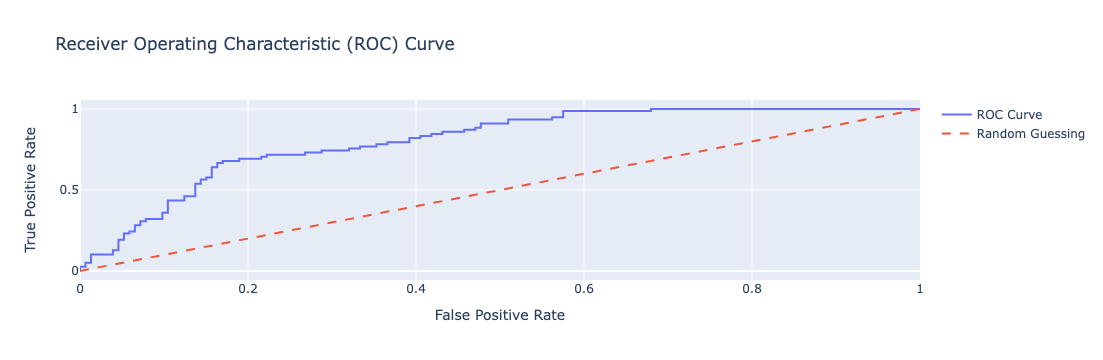


Support Vector Machine (SVM) with rbf kernel Performance Metrics:
Accuracy: 0.7662337662337663
Precision: 0.7386247877758914
Recall: 0.7355455002513827
F1 Score: 0.737012987012987


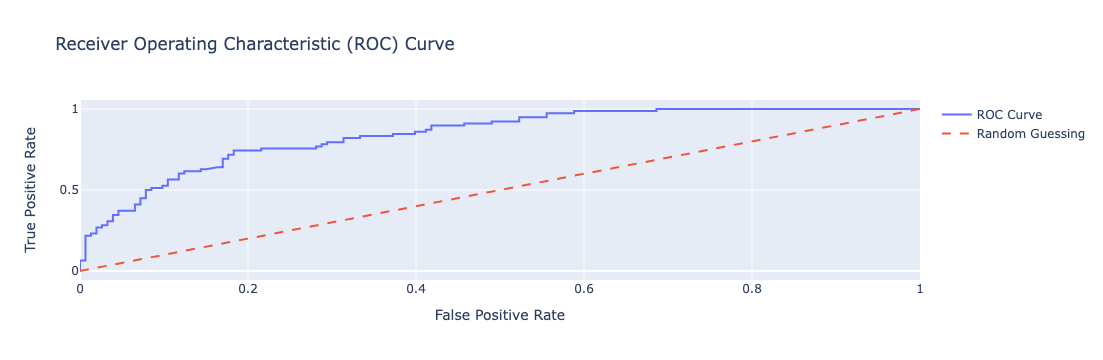


Support Vector Machine (SVM) with sigmoid kernel Performance Metrics:
Accuracy: 0.7272727272727273
Precision: 0.6934419014084507
Recall: 0.6841377576671694
F1 Score: 0.687951626391063


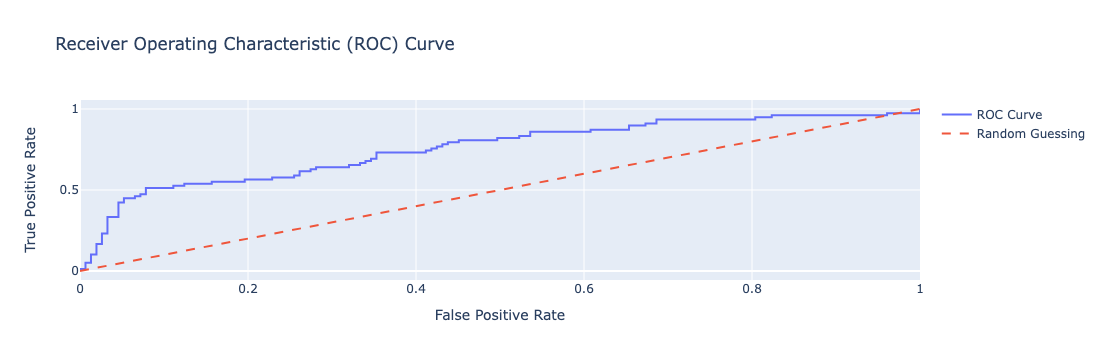

ValueError: Precomputed matrix must be a square matrix. Input is a 537x8 matrix.

In [118]:
for kernel in SVM_KERNELS:
    svm_classifier(kernel, X_train, y_train, X_test, y_test)    

# Değerlendirme

<img src="images/note.webp" alt="note" width="30" height="30"/> 

Farklı hiperparametreler ile kurulan farklı modellerin performansları aynı eğitim ve test setleri üzerinde değerlendirilmiştir. Bu çalışmalar sonucunda;

- KNN modellerinde hiperparametre optimizasyonu için yapılan farklı k (komşu) çalışmaları modelin performansına direkt etki etmiş olup, 20 k'ya kadar `accuracy` sonuçları artmış olup, 20'den fazla k için `accuracy` değeri düşmüştür. Bu kapsamda nihai model 20 k ile kurulmuş olup elde edilen accuracy değeri `0.77` olarak gözlemlenmiştir.
- Naive Bayes modeli için hiperparametre optimizasyonu yapılmamış olup `accuracy` değeri `0.77` olarak gözlemlenmiştir.
- SVM modellerinde hiperparametre optimizasyonu için yapılan farklı kernel (çekirdek) çalışmaları modelin performansını etkilemiştir. En iyi `accuracy` değeri `rbf` kullanılarak `0.76` olarak elde edilmiştir.
- MLP modelleri için `hiddem_layer_size` arttıkça model başarısının düştüğü gözlemlenmiştir. En iyi başarıyı veren `hidden_layer_size=2` ve `max_iter=300` hiperparametreleri ile final model kurulmuş olup `0.79` accuracy değeri elde edilmiştir. İterasyon sayısının 300'den fazla artırılmasının model başarısına etkisi olmamıştır.

En iyi `accuracy` sonuçlarını veren hiperparametreler ile kurulan modellere ait başarı değerlendirme metrikleri ve ROC curve figürleri aşağıda sunulmuştur.

## Best K-NN


K-Nearest Neighbors (K-NN) with 20 neighbors Performance Metrics:
Accuracy: 0.7705627705627706
Precision: 0.7442781690140845
Recall: 0.7325289089994973
F1 Score: 0.7374831142654974


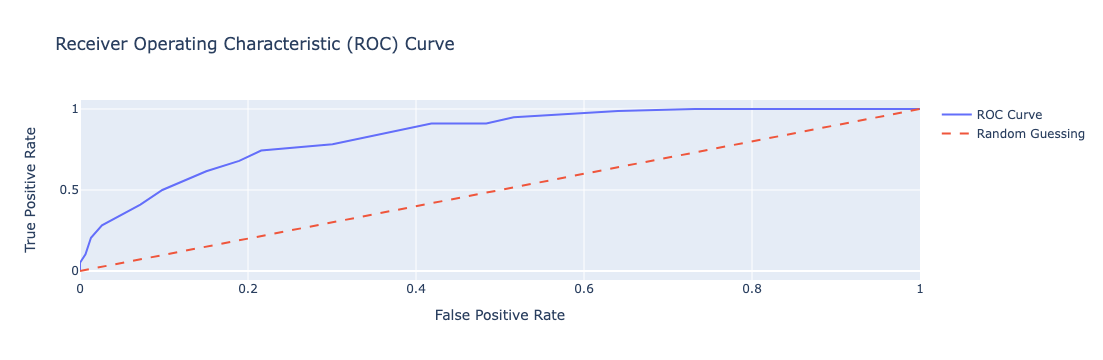

In [152]:
final_knn = knn_classifier(20, X_train, y_train, X_test, y_test)
final_knn_plot = plot_roc_curve_plotly(final_knn, X_test, y_test, False)
export_fig_as_png(final_knn_plot, "final_knn_fig")

![Final KNN](./figures/final_knn_fig.png)

## Best Naive


Naive Bayes Performance Metrics:
Accuracy: 0.7705627705627706
Precision: 0.7435064935064934
Recall: 0.741955756661639
F1 Score: 0.7427130398234738


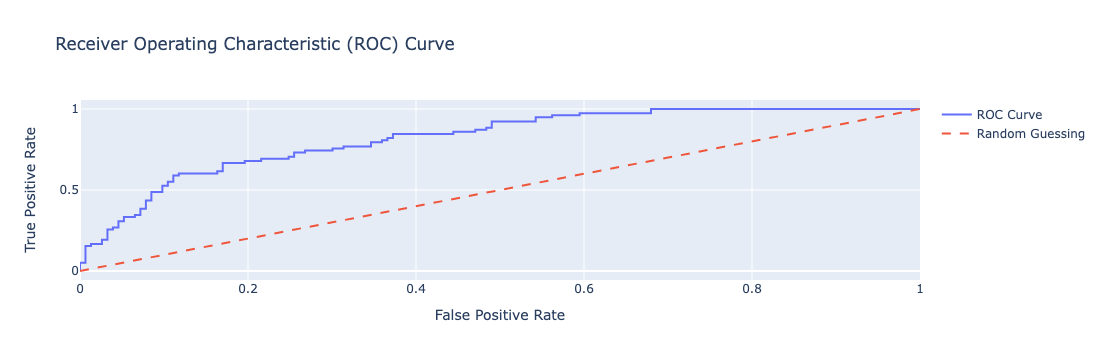

In [153]:
final_naive = naive_bayes(X_train, y_train, X_test, y_test)
final_naive_plot = plot_roc_curve_plotly(final_naive, X_test, y_test, False)
export_fig_as_png(final_naive_plot, "final_naive_fig")

![Final Naive](./figures/final_naive_fig.png)

## Best SVN


Support Vector Machine (SVM) with rbf kernel Performance Metrics:
Accuracy: 0.7662337662337663
Precision: 0.7386247877758914
Recall: 0.7355455002513827
F1 Score: 0.737012987012987


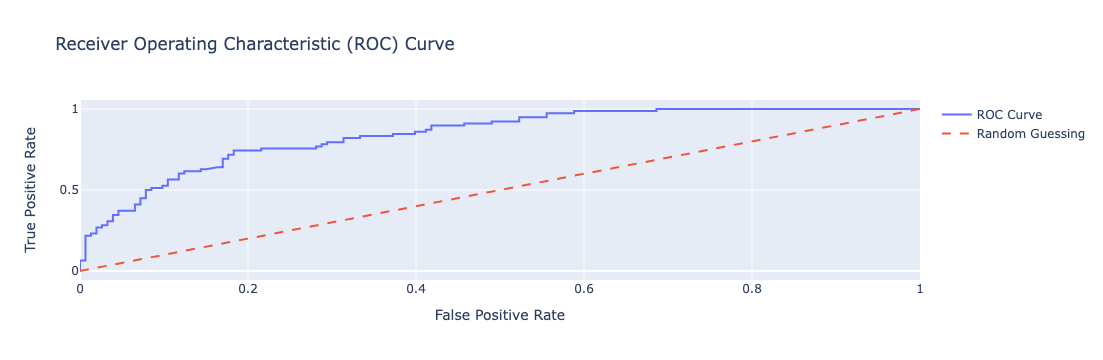

In [155]:
final_svn = svm_classifier("rbf", X_train, y_train, X_test, y_test)    
final_svn_plot = plot_roc_curve_plotly(final_svn, X_test, y_test, False)
export_fig_as_png(final_svn_plot, "final_svn_fig")

![Final SVN](./figures/final_svn_fig.png)

## Best MLP


Multi-Layer Perceptron (MLP) with hidden layers 2 and 300 iterations Performance Metrics:
Accuracy: 0.7922077922077922
Precision: 0.7713370624323349
Recall: 0.7520110608345902
F1 Score: 0.7596670712675568


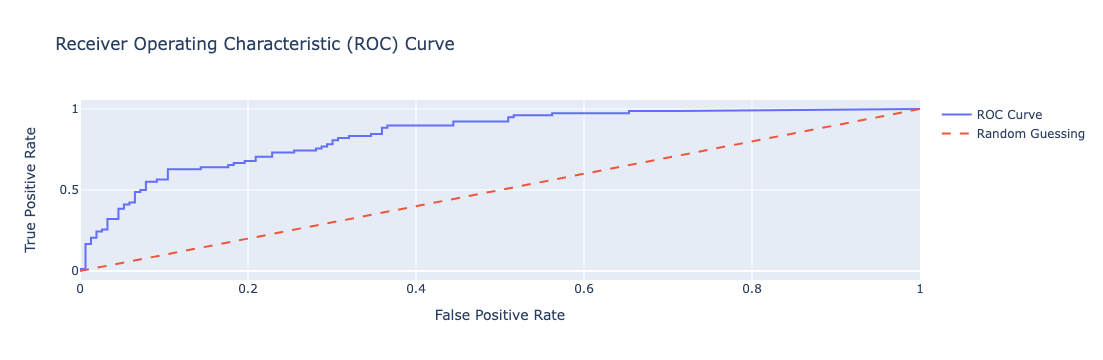

In [156]:
final_mlp = mlp_classifier(2, 300, X_train, y_train, X_test, y_test)
final_mlp_plot = plot_roc_curve_plotly(final_mlp, X_test, y_test, False)
export_fig_as_png(final_mlp_plot, "final_mlp_fig")

![Final MLP](./figures/final_mlp_fig.png)